# Laplace Approximation

## Theoretic Foundation

The Laplace Approximation (LA) is a Bayesian method that allows trained models to express epistemic uncertainty. It was made popular by David MacKay's 1992 [paper](https://authors.library.caltech.edu/13793/1/MACnc92b.pdf) titled "A Practical Bayesian Framework for Backpropagation Networks". 

In this setting, we define a prior distribution $p(\theta)$ over our network parameters. Because modern neural networks consists of millions of parameters, obtaining a posterior distribution over the weights $\theta$ is intractable. The LA

"[...] locally approximates the posterior with
a Gaussian distribution centered at a local maximum, with covariance matrix corresponding to the
local curvature. Two key advantages of the LA are that the local maximum is readily available from
standard maximum a posteriori (MAP) training of NNs, and that curvature estimates can be easily and
efficiently obtained thanks to recent advances in second-order optimization, both in terms of more
efficient approximations to the Hessian[...]" [Laplace Redux – Effortless Bayesian Deep Learning](https://arxiv.org/pdf/2106.14806.pdf).

Summarizing the above, the idea of the Laplace Approximation is to take the obtained MAP estimate of the parameters $\theta$ from a trained network $f_{\theta}(x) = \mu_{\theta}(x)$ and construct a Gaussian distribution around it. 

Here $\theta_{MAP} = \text{argmin} \mathcal{L}(\theta; \mathcal{D}),$
where in our case $\mathcal{L}(\theta; \mathcal{D}) := -\sum_{i=1}^n log(p(y_i|f_{\theta}(x_i)))$ and we chose the posterior $p(y_i|f_{\theta}(x_i))$ to be a Gaussian such that the loss is the mean squared error. Hence, we can use our deterministic MLP trained earlier with the MSE loss.

To do this we use, Bayes Theorem, as in  [Laplace Redux – Effortless Bayesian Deep Learning](https://arxiv.org/pdf/2106.14806.pdf), to get 

$p(\theta|D) = p(D\vert\theta)p(\theta)/p(D)= \frac{1}{Z} exp(- \mathcal{L}(\theta; D))$, 

with $Z = \int p(D\vert\theta)p(\theta) d\theta$. 

We now use a second-order expansion of $\mathcal{L}$ around $\theta_{MAP}$ to construct a Gaussian approximation to the posterior $p(\theta|D)$:

$-\mathcal{L}(\theta; D) \approx -\mathcal{L}(\theta_{MAP}; D)- \frac{1}{2}(\theta-\theta_{MAP}) (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP}) (\theta-\theta_{MAP}).$

The term with the first order derivative is zero as the loss is evaluated at a minimum $\theta_{MAP}$, [Probabilistic Machine Learning](https://probml.github.io/pml-book/book2.html), and, further, one assumes that the first term is neglible as the loss is evaluated at $\theta = \theta_{MAP}$. Then taking the expontential of both sides allows to identify, after normalization, the Laplace approximation,

\begin{align*}
p(\theta|D) \approx \mathcal{N}(\theta_{MAP}, \Sigma) && \Sigma =  (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP})^{-1}.
\end{align*}

With the definition of Gaussian distributions, we can write the above:

$p(\theta|D) \approx \frac{1}{(2\pi)^{W/2}}\frac{1}{|\Sigma|^{-1/2}}\exp{-\frac{1}{2}(x-\theta_{MAP})^T \Sigma^{-1} (x-\theta_{MAP})}$

And noting that the covariance is just the inverse Hessian of the loss, 

$\Sigma =  (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP})^{-1} = H^{-1}$, 

this gives us:

$p(\theta|D)\approx \mathcal{N}(\theta_{MAP}, H^{-1})$,

 where $\theta_{MAP}\in \mathcal{R}^W$ and $H^{-1}\in \mathcal{R}^{W\times W}$, with $W$ being the number of weights.

The computation of the Hessian term is still expensive. Therefore, further approximations are introduced in practice, most commonly the Generalized Gauss-Newton matrix ([GNN](https://jmlr.org/papers/volume21/17-678/17-678.pdf)).

This takes the following form:
$H \approx \widetilde{H}=\sum_{n=1}^NJ_n^TH_nJ_n$
where $J_n\in \mathcal{R}^{O\times W}$ is the Jacobian of the model outputs with respect to the parameters $\theta$ and $H_n\in\mathcal{R}^{O\times O}$ is the Hessian of the negative log-likelihood with respect to the model outputs. Here $O$ denotes the model output size and $W$ the number of parameters.

\begin{align*}
J_n=\frac{\partial f_{\theta}(x_n)}{\partial \theta} && H_n=\frac{-\partial^2\log(p(y|f_{\theta}(x_n))}{\partial^2 f_{\theta}(x_n)}
\end{align*}

This means, that we do not have to take the full second-order Hessian w.r.t all weights but can approximate it with a method that only requires more computationally cheaper derivatives.

During inference on unseen data, we cannot compute the full posterior predictive distribution but instead resort to sampling to approximate this distribution:
$\frac{1}{S}\sum_{s=1}^S p(y^{\star}|x^{\star}, \theta_s),$

where for each prediction input $x^*$ we make a total of S predictions, each time with a differently sampled parameter vector $\theta \sim p(\theta|D)$. The prediction is then obtained by computing the mean and variance, epistemic uncertainty, of the predictions obtained from the original MLP with S different parameters $\theta$. The mean is given by

$\hat{y}(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star}),$

and the squared variance by

$\sigma^2(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star})^2 - \hat{y}(x^{\star})^2.$

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import BaseModel, LaplaceModel
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

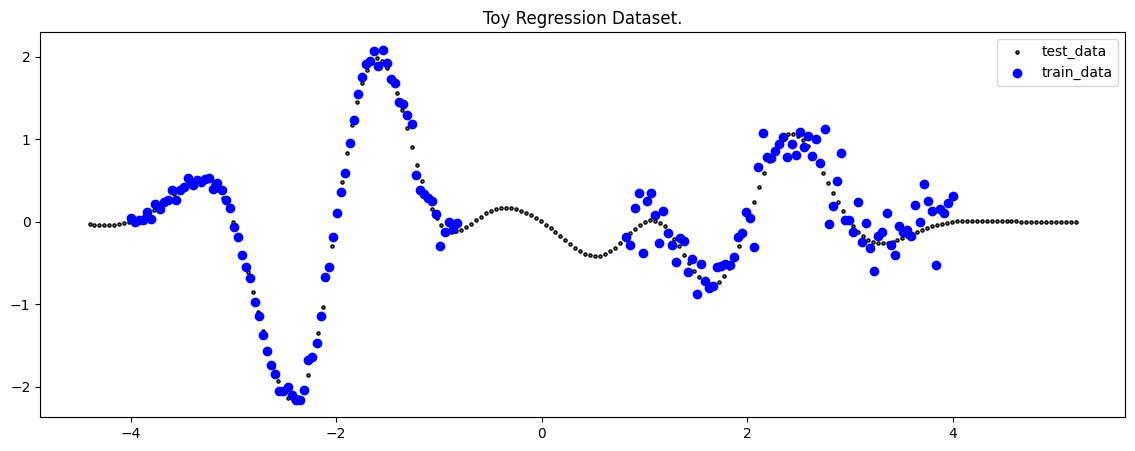

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP).

In [16]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

For the Laplace model, we first train a plain deterministic model to obtain a MAP estimate of the weights via the standard MSE loss. Subsequently, we fit the Laplace Approximation to obtain an estimate of the epistemic uncertainty for predictions.

In [17]:
deterministic_model = BaseModel(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=torch.nn.MSELoss(),
    save_dir=my_temp_dir,
)

## Trainer

Now that we have a LightningDataModule and base model, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [18]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [19]:
trainer.fit(deterministic_model, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | loss_fn       | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

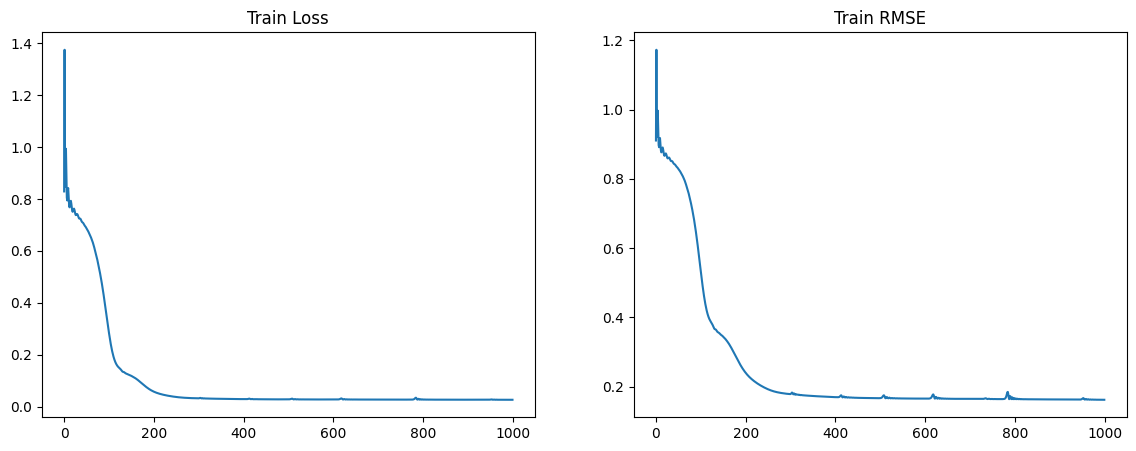

In [20]:
fig = plot_training_metrics(my_temp_dir)

## Fit Laplace

With a trained deterministic Model we can fit the Laplace Approximation with our LightningModule Wrapper. Under the hood, it uses the great [Laplace Library](https://aleximmer.github.io/Laplace/) that allows you to define different flavors of approximations. For small networks like in this example, one can fit the Laplace approximation over all weights, but this is not feasible for large million-parameter networks. In those cases, on can resort to a "last-layer" approximation, where only the last layer weights are stochastic, while all other weights are deterministic. This behavior is controlled with the `subset_of_weights` parameter. This is chosen in combination with the structure of the Hessian that is fitted, see the `hessian_structure` parameter.

In [21]:
laplace_model = LaplaceModel(
    model=deterministic_model.model,
    train_loader=train_loader,
    subset_of_weights="all",
    hessian_structure="full",
    save_dir=my_temp_dir,
)

In [22]:
preds = laplace_model.predict_step(X_test)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'lightning_uq_box.models.mlp.MLP'> although the module has parameters
  warnings.warn(
100%|██████████| 10/10 [00:01<00:00,  5.43it/s, neg_marglik=394.471435546875] 


## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile. The Laplace wrapper module will conduct the Laplace fitting procedure automatically before making the first prediction and will use it for any subsequent call to sample network weights for the desired number of Monte Carlo samples.

In [23]:
preds = laplace_model.predict_step(X_test)

## Evaluate Predictions

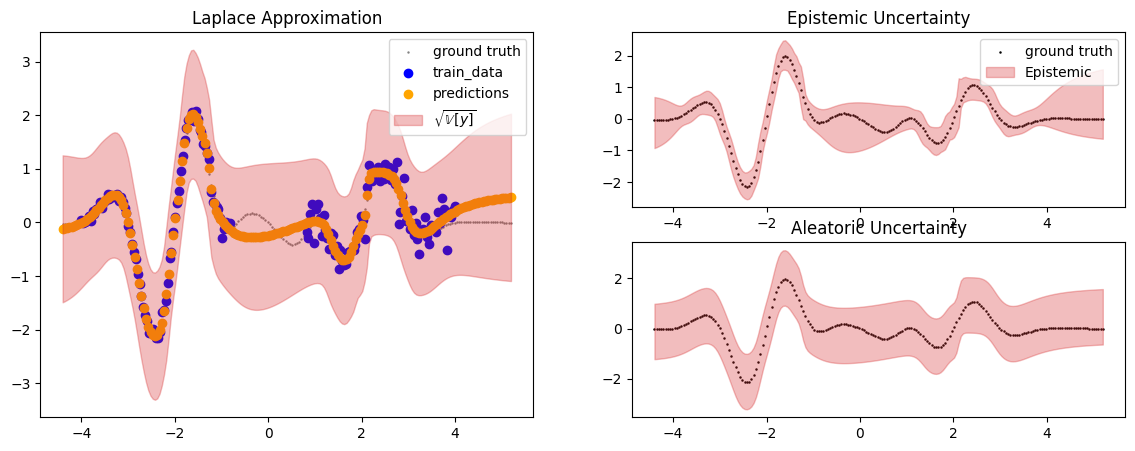

In [24]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Laplace Approximation",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

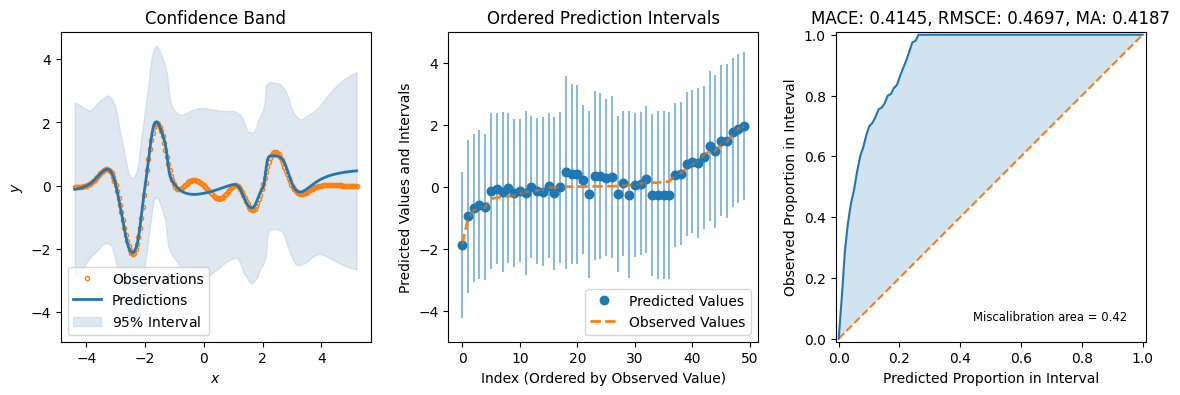

In [25]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

[Immer et al. 2021](https://arxiv.org/abs/2008.08400) showed that a linearization of the model achieves better performance in practice:
$f_{\theta}(x)=f_{\theta_{MAP}}(x)+ J_{\theta_{MAP}}(\theta-\theta_{MAP})$

[Daxberger et al. 2020](https://arxiv.org/abs/2010.14689) introduced a subnetwork selection strategy that turns selected weights "Bayesian" while keeping the rest of the network deterministic and show performance on par with deep ensembles.